## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [2]:
import math as m
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%precision 4
from scipy import stats

import os
os.environ["NUMBA_ENABLE_CUDASIM"] = "1"
from numba import jit, njit, vectorize, cuda, float64

from __future__ import division

In [2]:
#from numba import vectorize, float64

@vectorize([float64(float64)])
def exponential(x):
    return m.exp(x)

@vectorize([float64(float64)])
def logarithm(x):
    return m.log(x)

A = np.array([2, 5, 10, 3, 8])
e_A = exponential(A)
l_A = logarithm(A)
print("A = ", A)
print("exp(A) = ", e_A)
print("log(A) = ", l_A)

A =  [ 2  5 10  3  8]
exp(A) =  [7.3891e+00 1.4841e+02 2.2026e+04 2.0086e+01 2.9810e+03]
log(A) =  [0.6931 1.6094 2.3026 1.0986 2.0794]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

In [3]:
#from numba import vectorize, float64

@vectorize([float64(float64, float64)], nopython=True)
def dist(axis, t):
    if -3<=t and t<3:
        diff = abs(axis - t)
    return diff

@vectorize([float64(float64, float64, float64)], nopython=True)
def point(mn, axis, t):
    P = 0
    if abs(axis - t) == mn:
        P = axis
    return P

X = -1.1234567 #whatever x axis point inside range (-3, 3)
X = float(X)

x = np.linspace(-3, 3, 100000).astype(np.float64)

gauss = stats.norm.pdf(x)
gauss = gauss.astype(np.float64)

p = dist(x, X)
minimum = np.min(p)
pt = point(minimum, x, X)
val = stats.norm.pdf(pt[pt != 0])
print("Value of a Gaussian pdf with size = 100000 at X: ", val)


Value of a Gaussian pdf with size = 100000 at X:  [0.2122]


## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

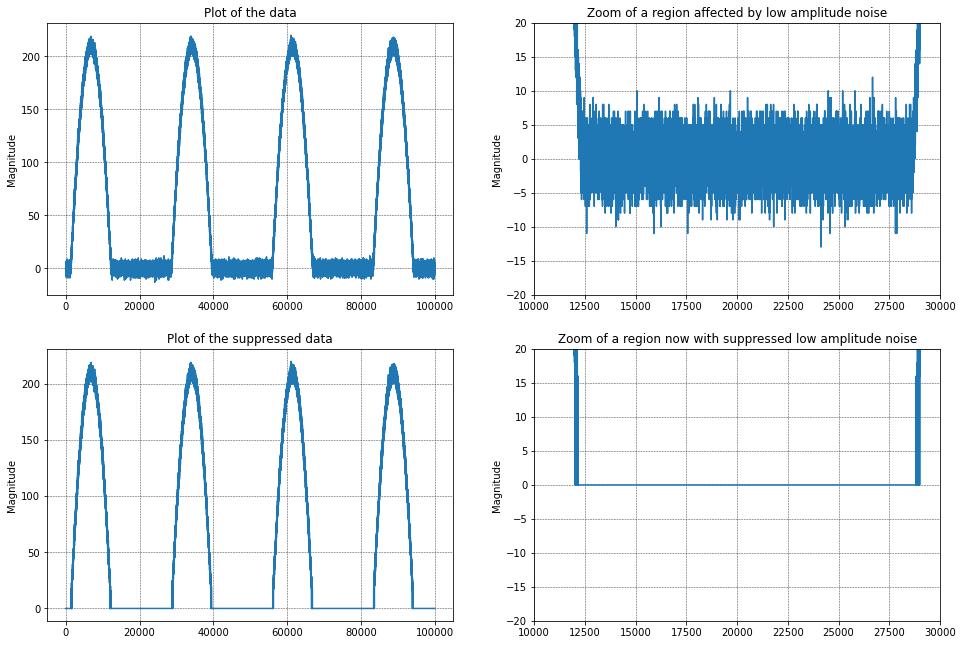

In [4]:
#%matplotlib inline
#from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

#put your code here
x = np.arange(n)

fig1 = plt.figure(figsize=(16, 11))
ax1 = fig1.add_subplot(221)
ax1.plot(x, data)
ax1.set_title("Plot of the data")
ax1.set_ylabel("Magnitude")
ax1.grid(linestyle="--", linewidth=0.5, color='.25')
ax2 = fig1.add_subplot(222)
ax2.plot(x, data)
ax2.set_title("Zoom of a region affected by low amplitude noise")
ax2.set_ylabel("Magnitude")
ax2.set_xlim(10000, 30000)
ax2.set_ylim(-20, 20)
ax2.grid(linestyle="--", linewidth=0.5, color='.25')

@vectorize([float64(float64, float64)], nopython=True)
def zero_suppress(original, threshold):
    if abs(original) > threshold:
        modified = original
    elif abs(original) <= threshold:
        modified = 0
    return modified

thrshld = 15
suppressed = zero_suppress(data, thrshld)

ax3 = fig1.add_subplot(223)
ax3.plot(x, suppressed)
ax3.set_title("Plot of the suppressed data")
ax3.set_ylabel("Magnitude")
ax3.grid(linestyle="--", linewidth=0.5, color='.25')
ax4 = fig1.add_subplot(224)
ax4.plot(x, suppressed)
ax4.set_title("Zoom of a region now with suppressed low amplitude noise")
ax4.set_ylabel("Magnitude")
ax4.set_xlim(10000, 30000)
ax4.set_ylim(-20, 20)
ax4.grid(linestyle="--", linewidth=0.5, color='.25')

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [73]:
# CUDA kernel
@cuda.jit(device=True)
def transpose(io_array, T_io_array):
    #row, col = cuda.grid(2)
    #if row < io_array.shape[0] and col < io_array.shape[1]:
    for i in range(io_array.shape[0]):
        for j in range(io_array.shape[1]):
            T_io_array[i][j] = io_array[j][i]
    return T_io_array
        
@cuda.jit(device=True)
def matrices_prod(a, b, c):
    #row, col = cuda.grid(2)
    #if row < c.shape[0] and col < c.shape[1]:
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            tmp = 0.
            for k in range(a.shape[1]):
                tmp += a[i, k] * b[k, j]
            c[i, j] = tmp
    return c

@cuda.jit
def sigmoid_kernel(x, y, alpha, beta, s_k, xt, xty):
    T_io_array = transpose(x, xt)
    c = matrices_prod(T_io_array, y, xty)
    row, col = cuda.grid(2)
    if row < c.shape[0] and col < c.shape[1]:
        s_k[row][col] = m.tanh((alpha*c[row][col])+beta)

# Host code 
X = np.random.rand(3, 3)
Y = np.random.rand(3, 3)
X_T = np.zeros((3, 3))
X_TY = np.zeros((3, 3))
S_K = np.zeros((3, 3))
Alpha = 1
Beta = 0
print("X =", X, '\n')
print("Y =", Y, '\n')
print("alpha =", Alpha, '\n')
print("c =", Beta, '\n')

# Configure the blocks
threadsperblock = (3, 1)
blockspergrid_x = int(m.ceil(X.shape[0] / threadsperblock[0]))
blockspergrid_y = int(m.ceil(X.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

#transpose[blockspergrid, threadsperblock](X, X_T)
#print("X_T =", X_T, '\n')
#matrices_prod[blockspergrid, threadsperblock](X_T, Y, X_TY)
#print("X_T*Y =", X_TY, '\n')
sigmoid_kernel[blockspergrid, threadsperblock](X, Y, Alpha, Beta, S_K, X_T, X_TY)
print("k(X, Y) =", S_K)

X = [[0.508  0.6288 0.9903]
 [0.7648 0.0851 0.0751]
 [0.1895 0.1604 0.9156]] 

Y = [[0.7305 0.6608 0.3296]
 [0.5234 0.9301 0.5215]
 [0.4046 0.7122 0.188 ]] 

alpha = 1 

c = 0 

k(X, Y) = [[0.6901 0.8281 0.5384]
 [0.5145 0.5434 0.2746]
 [0.8121 0.8801 0.4912]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [42]:
# CUDA kernel
@cuda.jit
def cos_3D(io_array):
    x, y, z = cuda.grid(3)
    if x < io_array.shape[0] and y < io_array.shape[1] and z < io_array.shape[2]:
        io_array[x][y][z] = m.cos(io_array[x][y][z]) # do the computation

# Host code   
data = np.random.random((256, 256, 256))

# Configure the blocks
threadsperblock = (16, 4, 4)
blockspergrid_x = int(m.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(m.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid_z = int(m.ceil(data.shape[2] / threadsperblock[2]))
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)

cos_3D[blockspergrid, threadsperblock](data)
print(data)
#code keeps running without stopping

KeyboardInterrupt: 

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [4]:
#from __future__ import division
#from numba import cuda
#import numpy
#import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.randint(10, size=(24, 12))
B = np.random.randint(10, size=(12, 22))
C = np.zeros((24, 12))

# Configure the blocks
threadsperblock = (12, 2)
blockspergrid_x = int(m.ceil(C.shape[0] / threadsperblock[0]))
blockspergrid_y = int(m.ceil(C.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

#threadsperblock = (3, 1)
#blockspergrid_x = int(m.ceil(X.shape[0] / threadsperblock[0]))
#blockspergrid_y = int(m.ceil(X.shape[1] / threadsperblock[1]))
#blockspergrid = (blockspergrid_x, blockspergrid_y)

matmul[blockspergrid, threadsperblock](A, B, C)
print("A =", A, '\n')
print("B =", B, '\n')
print("C =", C, '\n')
print("Matrix product between A and B:\n", np.matmul(A, B))

A = [[5 3 0 9 4 6 5 0 6 0 2 4]
 [1 6 8 4 3 4 7 9 0 7 1 2]
 [3 8 2 0 9 3 8 2 0 6 3 8]
 [2 3 5 9 7 5 2 3 1 0 8 4]
 [5 2 1 5 6 9 1 3 9 6 9 6]
 [8 4 9 3 1 7 9 4 3 0 8 5]
 [8 3 0 0 2 6 9 9 3 4 3 6]
 [8 1 1 8 8 4 0 3 5 7 4 1]
 [2 4 2 9 5 5 7 2 2 4 7 9]
 [3 4 2 1 0 8 4 2 9 4 0 8]
 [6 7 6 5 0 1 8 4 6 1 0 7]
 [5 9 3 9 9 3 8 9 5 6 0 8]
 [2 7 2 8 5 1 2 8 0 1 2 0]
 [5 7 0 7 5 8 1 3 6 0 0 2]
 [5 6 6 7 3 1 4 7 2 2 9 0]
 [2 6 6 2 1 8 1 1 2 5 7 9]
 [0 0 2 9 4 1 3 2 2 0 8 8]
 [6 3 8 6 3 9 0 1 8 7 7 0]
 [3 3 9 4 7 4 9 5 7 3 1 6]
 [2 6 9 3 4 4 4 8 6 7 3 3]
 [4 7 7 9 9 0 6 9 7 0 7 9]
 [3 6 2 5 5 6 6 0 5 2 8 7]
 [6 4 9 3 0 1 3 1 5 8 4 5]
 [5 4 5 5 8 2 9 7 1 3 1 2]] 

B = [[9 9 6 3 5 6 3 2 1 7 5 3 7 6 2 3 1 8 4 0 0 7]
 [5 2 9 9 1 9 2 9 6 2 7 7 0 9 6 4 2 7 9 3 1 8]
 [7 4 3 7 2 1 2 7 3 1 3 9 5 2 5 9 7 0 8 2 1 3]
 [7 3 4 1 4 8 1 3 7 6 0 5 9 1 4 9 6 8 7 1 7 3]
 [2 7 4 1 5 9 5 7 8 4 2 0 6 3 5 7 9 0 4 5 4 3]
 [0 3 9 8 2 8 1 1 1 8 1 4 1 9 9 1 7 9 8 9 7 5]
 [7 8 3 7 0 2 8 7 2 9 3 1 5 1 8 6 4 0 3 0 8 4]
 [3 2 3 7 9 